In [1]:
import os
import numpy as np
import pandas as pd
import talib
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

path = os.getcwd()
data = pd.read_csv(path+'/BTC_PERP.csv', parse_dates=True, index_col='startTime')
funding = pd.read_csv(path+'/BTC_funding.csv', parse_dates=True, index_col='time')

C:\Users\gantm


In [3]:
def fundingPayment(df_funding, side, unit, t1, t2):
    if len(df_funding.loc[t1:t2]) == 0:
        fee = 0
    else:
        fr = np.array(df_funding.loc[t1:t2])
        fee = unit*np.dot(fr[:, 0], fr[:, 1])
    if side =='long':
        return -fee
    elif side == 'short':
        return fee

In [4]:

df_hour = data.resample(rule = '1H', closed='left', label='left').first()[['open']]
df_funding = pd.concat([df_hour, funding], axis=1)
df_funding = df_funding.fillna(method = 'bfill', limit = 2).fillna(0)


In [288]:
#樣本內
#固定停損

optimizationList = []
df_inSample = data.loc[:'2022-2']

fund = 10000
money = 10000
feeRate = 0.003
# length = 40
# stdTimes = 2
rule = '1D'
K=0.06

d1 = df_inSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = df_inSample.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = df_inSample.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = df_inSample.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = df_inSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)

for length_short in range(5,20):
    for length_long in range(30,50,2):
        
            #print('----------')
            #print(f'length_short: {length_short}')
            #print(f'length_long: {length_long}')

            
            dif, dem, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
            df['mashort'] = df['close'].rolling(window=length_short, center=False).mean()
            df['malong'] = df['close'].rolling(window=length_long, center=False).mean()
            df['macdhist'] = macdhist
        

            time_arr = np.array(df.index)
            df_arr = np.array(df)

            BS = None
            buy = []
            sell = []
            sellshort = []
            buytocover = []
            profit_list = [0]
            profit_fee_list = [0]
            profit_fee_list_realized = []

            for i in range(len(df_arr)):

                if i == len(df_arr)-1:
                    break

                if BS == None:
                    profit_list.append(0)
                    profit_fee_list.append(0)

                    if df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0:
                        tempSize = money / df_arr[i+1,0]
                        BS = 'B'
                        t = i+1
                        buy.append(t)
                        t1 = time_arr[i+1]

                    elif df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0:
                        tempSize = money / df_arr[i+1,0]
                        BS = 'S'
                        t = i+1
                        sellshort.append(t)
                        t1 = time_arr[i+1]

                elif BS == 'B':
                    profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
                    profit_list.append(profit)
                    t2 = time_arr[i+1]
                    fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)

                    if df_arr[i,3] < df_arr[t,3]*(1-K):
                        pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                        profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                        profit_fee_list.append(profit_fee)
                        sell.append(i+1)
                        BS=None
                
                    elif (df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0) or i == len(df_arr)-2:
                        pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                        profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                        profit_fee_list.append(profit_fee)
                        sell.append(i+1)
                        BS=None

                        # Realized PnL
                        profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                        profit_fee_list_realized.append(profit_fee_realized)

                    else:
                        profit_fee = profit
                        profit_fee_list.append(profit_fee)
                        t1 = time_arr[i+1]

                elif BS == 'S': 
                    profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
                    profit_list.append(profit)
                    t2 = time_arr[i+1]
                    fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)

                    if df_arr[i,3] > df_arr[t,3]*(1+K):
                        pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                        profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                        profit_fee_list.append(profit_fee)
                        sell.append(i+1)
                        BS=None
                    
                    elif (df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0) or i == len(df_arr)-2:
                        pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
                        profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                        profit_fee_list.append(profit_fee)
                        buytocover.append(i+1)
                        BS=None

                        # Realized PnL
                        profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                        profit_fee_list_realized.append(profit_fee_realized)

                    else:
                        profit_fee = profit
                        profit_fee_list.append(profit_fee)
                        t1 = time_arr[i+1]

            equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
            equity['equity'] = equity['profitfee'] + fund
            equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
            equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
            ret = equity['equity'][-1]/equity['equity'][0] - 1
            mdd = abs(equity['drawdown_percent'].min())
            calmarRatio = ret / mdd
        
            optimizationList.append([length_short, length_long,  ret, calmarRatio])
        
        
        
        
        

In [15]:
df.iloc[:3]

,open,high,low,close,volume,mashort,malong,macdhist
startTime,,,,,,,,
2020-12-31 00:00:00+00:00,28795.5,29213.5,28320.0,28956.5,5.831936e+08,NaN,NaN,NaN
2021-01-01 00:00:00+00:00,28956.0,29731.0,28675.0,29410.5,1.191753e+09,NaN,NaN,NaN
2021-01-02 00:00:00+00:00,29410.5,33486.5,29028.0,32201.5,3.612341e+09,NaN,NaN,NaN


In [148]:
#樣本內
#策略最佳化

optimizationList = []
df_inSample = data.loc[:'2022-2']

fund = 10000
money = 10000
feeRate = 0.0015
# length = 40
# stdTimes = 2
rule = '1D'
K=0.4

df_hour = data.resample(rule = '1H', closed='left', label='left').first()[['open']]
df_funding = pd.concat([df_hour, funding], axis=1)
df_funding = df_funding.fillna(method = 'bfill', limit = 2).fillna(0)

d1 = df_inSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = df_inSample.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = df_inSample.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = df_inSample.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = df_inSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)

for length_short in range(5,25,5):
    for length_long in range(30,50,5):
        for CCI in range(100,135,5):
            for K in np.arange(0.2,0.5, 0.1):       #平均獲利20%，所以停利設在20%以上

            
                    
            
                print('----------')
                print(f'length_short: {length_short}')
                print(f'length_long: {length_long}')
                print(f'CCI:{CCI}')
                print(f'K:{K}')

            
                dif, dem, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
                cci = talib.CCI(df.high, df.low, df.close, timeperiod=14)
                df['mashort'] = df['close'].rolling(window=length_short, center=False).mean()
                df['malong'] = df['close'].rolling(window=length_long, center=False).mean()
                df['macdhist'] = macdhist
                df['cci']=cci
            

                time_arr = np.array(df.index)
                df_arr = np.array(df)

                BS = None
                buy = []
                sell = []
                sellshort = []
                buytocover = []
                profit_list = [0]
                profit_fee_list = [0]
                profit_fee_list_realized = []

                for i in range(len(df_arr)):

                    if i == len(df_arr)-1:
                        break

                    if BS == None:
                        profit_list.append(0)
                        profit_fee_list.append(0)

                        if df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0 and df_arr[i,8] >= CCI:
                            tempSize = money / df_arr[i+1,0]
                            BS = 'B'
                            t = i+1
                            buy.append(t)
                            t1 = time_arr[i+1]

                        elif df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0 and df_arr[i,8] <= -CCI:
                            tempSize = money / df_arr[i+1,0]
                            BS = 'S'
                            t = i+1
                            sellshort.append(t)
                            t1 = time_arr[i+1]

                    elif BS == 'B':
                        profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
                        profit_list.append(profit)
                        t2 = time_arr[i+1]
                        fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)

                        #停損設1%，停利K
                        if df_arr[i,3] < df_arr[t,3]*(1-0.01) or df_arr[i,3] > df_arr[t,3] * (1+K):
                            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list.append(profit_fee)
                            sell.append(i+1)
                            BS=None
                            
                            # Realized PnL
                            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list_realized.append(profit_fee_realized)
                        
                        
                        elif (df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0) or i == len(df_arr)-2:
                            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list.append(profit_fee)
                            sell.append(i+1)
                            BS=None

                            # Realized PnL
                            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list_realized.append(profit_fee_realized)

                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
                            t1 = time_arr[i+1]

                    elif BS == 'S': 
                        profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
                        profit_list.append(profit)
                        t2 = time_arr[i+1]
                        fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)

                        if df_arr[i,3] > df_arr[t,3]*(1+0.01) or df_arr[i,3] < df_arr[t,3]*(1-K):
                            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
                            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list.append(profit_fee)
                            buytocover.append(i+1)
                            BS=None
                            
                            # Realized PnL
                            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list_realized.append(profit_fee_realized)
                        
                        elif (df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0) or i == len(df_arr)-2:
                            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
                            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list.append(profit_fee)
                            buytocover.append(i+1)
                            BS=None

                            # Realized PnL
                            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                            profit_fee_list_realized.append(profit_fee_realized)

                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
                            t1 = time_arr[i+1]

                equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
                equity['equity'] = equity['profitfee'] + fund
                equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
                equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
                ret = equity['equity'][-1]/equity['equity'][0] - 1
                mdd = abs(equity['drawdown_percent'].min())
                calmarRatio = ret / mdd
        
                optimizationList.append([length_short, length_long,CCI,  ret, calmarRatio, K])
optResult = pd.DataFrame(optimizationList, columns=['length_short','length_long','CCI','ret','calmarRatio','K'])
        

----------
length_short: 5
length_long: 30
CCI:100
K:0.2
----------
length_short: 5
length_long: 30
CCI:100
K:0.30000000000000004
----------
length_short: 5
length_long: 30
CCI:100
K:0.4000000000000001
----------
length_short: 5
length_long: 30
CCI:105
K:0.2
----------
length_short: 5
length_long: 30
CCI:105
K:0.30000000000000004
----------
length_short: 5
length_long: 30
CCI:105
K:0.4000000000000001
----------
length_short: 5
length_long: 30
CCI:110
K:0.2
----------
length_short: 5
length_long: 30
CCI:110
K:0.30000000000000004
----------
length_short: 5
length_long: 30
CCI:110
K:0.4000000000000001
----------
length_short: 5
length_long: 30
CCI:115
K:0.2
----------
length_short: 5
length_long: 30
CCI:115
K:0.30000000000000004
----------
length_short: 5
length_long: 30
CCI:115
K:0.4000000000000001
----------
length_short: 5
length_long: 30
CCI:120
K:0.2
----------
length_short: 5
length_long: 30
CCI:120
K:0.30000000000000004
----------
length_short: 5
length_long: 30
CCI:120
K:0.4000000

In [17]:
optResult.sort_values('ret', ascending=False).head(10)

,length_short,length_long,CCI,ret,calmarRatio,K
29,5,35,110,1.301809,10.369109,0.4
26,5,35,105,1.301809,10.369109,0.4
32,5,35,115,1.222587,9.276551,0.4
38,5,35,125,1.180924,7.932862,0.4
35,5,35,120,1.180924,7.932862,0.4
23,5,35,100,1.121791,5.523667,0.4
41,5,35,130,1.092005,5.667501,0.4
31,5,35,115,0.999835,7.845229,0.3
203,15,35,120,0.960232,4.482095,0.4
34,5,35,120,0.958172,6.047492,0.3


In [11]:
optResult = pd.DataFrame(optimizationList, columns=['length_short','length_long','CCI','ret','calmarRatio'])

In [12]:
optResult.sort_values('ret', ascending=False).head(30)

,length_short,length_long,CCI,ret,calmarRatio
8,5,35,105,1.301809,10.369109
9,5,35,110,1.301809,10.369109
10,5,35,115,1.222587,9.276551
11,5,35,120,1.180924,7.932862
12,5,35,125,1.180924,7.932862
7,5,35,100,1.121791,5.523667
13,5,35,130,1.092005,5.667501
67,15,35,120,0.960232,4.482095
2,5,30,110,0.930252,4.306699
3,5,30,115,0.930252,4.306699


In [145]:
#樣本內回測

K=0.4
length_short=5
length_long=35
CCI=105

df_inSample = data.loc[:'2022-2']
d1 = df_inSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d1 = df_inSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = df_inSample.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = df_inSample.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = df_inSample.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = df_inSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)
dif, dem, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
cci = talib.CCI(df.high, df.low, df.close, timeperiod=14)
df['mashort'] = df['close'].rolling(window=length_short, center=False).mean()
df['malong'] = df['close'].rolling(window=length_long, center=False).mean()
df['macdhist'] = macdhist
df['cci'] = cci
        
time_arr = np.array(df.index)
df_arr = np.array(df)

BS = None
buy = []
sell = []
sellshort = []
buytocover = []
BSlist=[]
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0 and df_arr[i,8] >= CCI:
            tempSize = money / df_arr[i+1,0]
            BS = 'B'
            t = i+1
            buy.append(t)
            t1 = time_arr[i+1]
            BSlist.append('B')

        elif df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0 and df_arr[i,8] <= -CCI:
            tempSize = money / df_arr[i+1,0]
            BS = 'S'
            t = i+1
            sellshort.append(t)
            t1 = time_arr[i+1]
            BSlist.append('S')

    elif BS == 'B':
        profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)

        if df_arr[i,3] < df_arr[t,3]*(1-0.01):
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            buy_profit += profit_fee_realized
            buy_profit_fee_realized_list.append(profit_fee_realized)
            
        elif df_arr[i,3] > df_arr[t,3] * (1+K):
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        
        elif (df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0) or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]

    elif BS == 'S': 
        profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)

        if df_arr[i,3] > df_arr[t,3]*(1+0.01):
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
            
        elif df_arr[i,3] < df_arr[t,3]*(1-K):
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
                            
        elif (df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0) or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
equity['day_ret'] = equity['equity'].pct_change(1)
ret = equity['equity'][-1]/equity['equity'][0] - 1   #總報酬(未年化)
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
profit = equity['profitfee'].iloc[-1]
yearstd = equity['day_ret'].std()*365**0.5  #年化波動度=日報酬標準差*(交易天數)^0.5
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
annualizedreturn = ret*12/14    #年化報酬，以單利計算
sharperatio = annualizedreturn / yearstd   #年化報酬率 / 年化波動度

In [146]:

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'annualizedreturn: {np.round(annualizedreturn, 4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'yearstd:{yearstd}')
print(f'sharperatio: {sharperatio}')
print(sum([i for i in profit_fee_list_realized if i > 0]))
print(sum([i for i in profit_fee_list_realized if i < 0]))

profit: $13018.09
return: 130.18%
annualizedreturn: 111.57999999999998%
mdd: 12.55%
calmarRatio: 10.37
tradeTimes: 18
winRate: 38.89%
profitFactor: 4.66
winLossRatio: 7.32
yearstd:0.3773919948713348
sharperatio: 2.9567039157251855
16574.806209970113
-3556.7150049769484


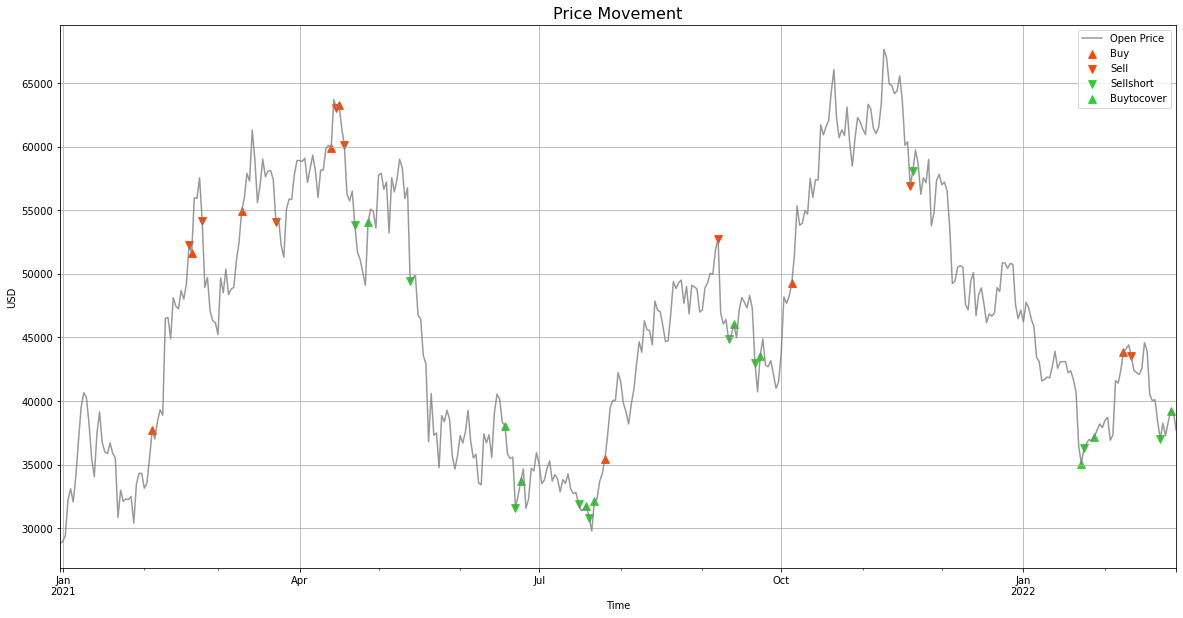

In [147]:
#價格移動圖
fig, ax = plt.subplots(figsize = (20,10))
df['open'].plot(label = 'Open Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['open'].iloc[buy].index, df['open'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['open'].iloc[sell].index, df['open'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['open'].iloc[sellshort].index, df['open'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['open'].iloc[buytocover].index, df['open'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

<AxesSubplot:xlabel='startTime'>

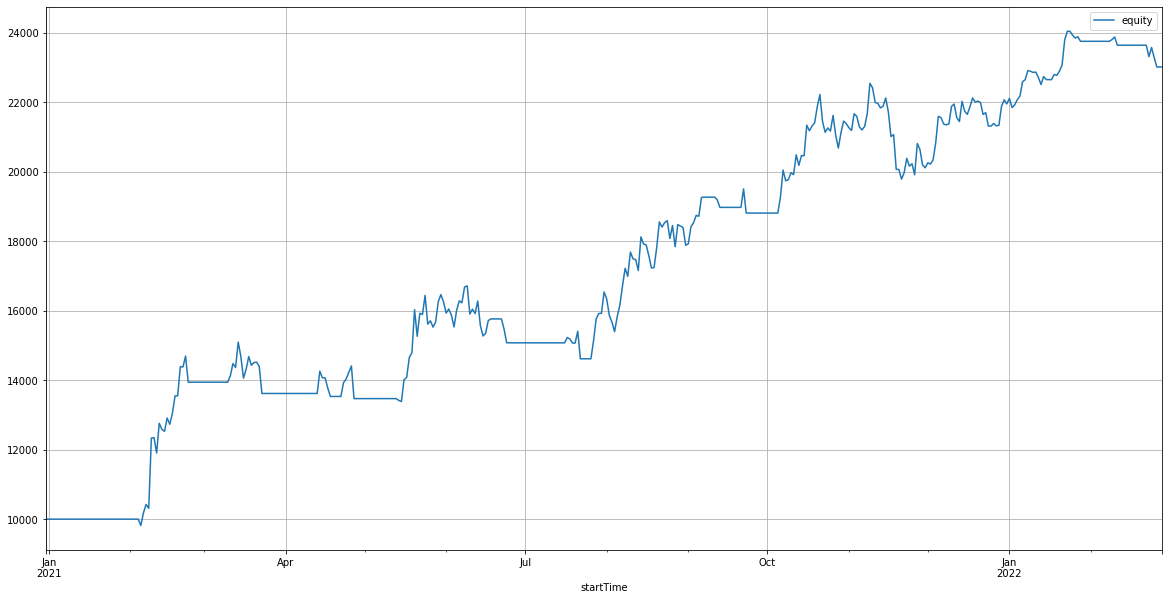

In [74]:
equity[['equity']].plot(figsize=(20,10), grid=True)

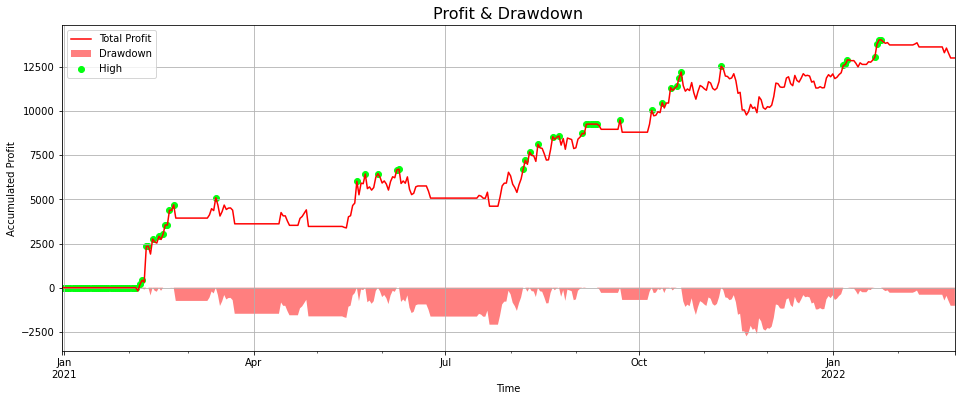

In [86]:

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

In [149]:
#樣本外回測

K=0.4
length_short=5
length_long=35
CCI=105

df_outSample = data.loc['2022-3':]
d1 = df_outSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d1 = df_outSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = df_outSample.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = df_outSample.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = df_outSample.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = df_outSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)
dif, dem, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
cci = talib.CCI(df.high, df.low, df.close, timeperiod=14)
df['mashort'] = df['close'].rolling(window=length_short, center=False).mean()
df['malong'] = df['close'].rolling(window=length_long, center=False).mean()
df['macdhist'] = macdhist
df['cci'] = cci
        
time_arr = np.array(df.index)
df_arr = np.array(df)

BS = None
buy = []
sell = []
sellshort = []
buytocover = []
BSlist=[]
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0 and df_arr[i,8] >= CCI:
            tempSize = money / df_arr[i+1,0]
            BS = 'B'
            t = i+1
            buy.append(t)
            t1 = time_arr[i+1]
            BSlist.append('B')

        elif df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0 and df_arr[i,8] <= -CCI:
            tempSize = money / df_arr[i+1,0]
            BS = 'S'
            t = i+1
            sellshort.append(t)
            t1 = time_arr[i+1]
            BSlist.append('S')

    elif BS == 'B':
        profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)

        if df_arr[i,3] < df_arr[t,3]*(1-0.01):
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
            
        elif df_arr[i,3] > df_arr[t,3] * (1+K):
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        elif (df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0) or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]

    elif BS == 'S': 
        profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)

        if df_arr[i,3] > df_arr[t,3]*(1+0.01):
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
                        
        elif df_arr[i,3] < df_arr[t,3]*(1-K):
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
                                        
        elif (df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0) or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
equity['day_ret'] = equity['equity'].pct_change(1)
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
profit = equity['profitfee'].iloc[-1]
yearstd = equity['day_ret'].std()*365**0.5
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
annualizedreturn = ret*12/5
sharperatio = annualizedreturn / yearstd

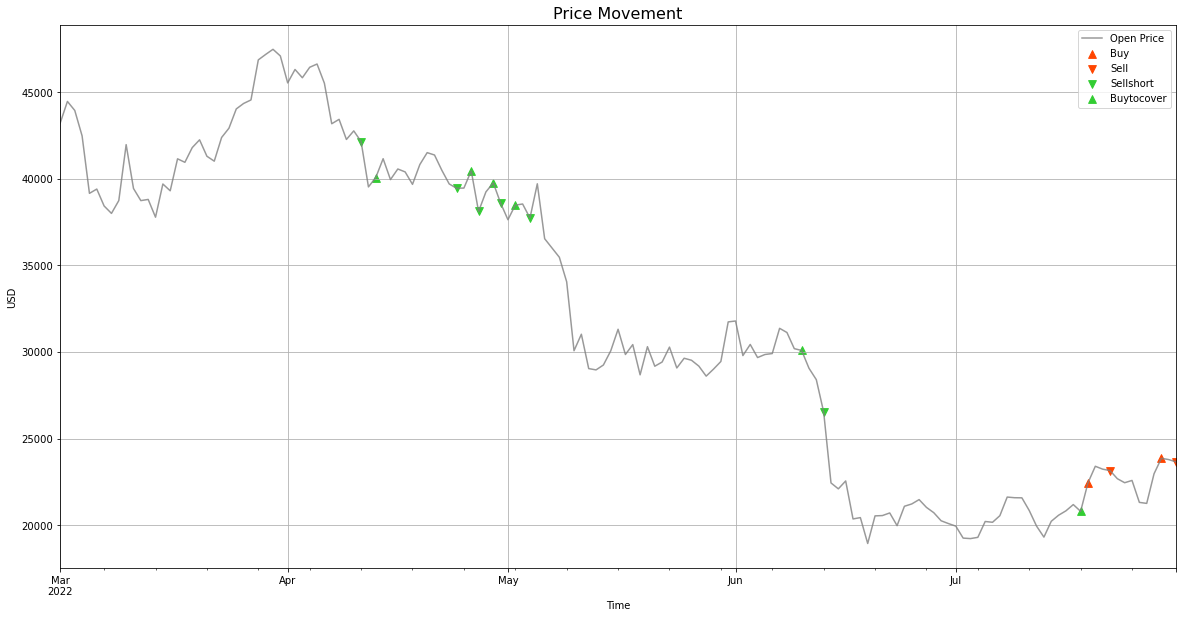

In [150]:
fig, ax = plt.subplots(figsize = (20,10))

df['open'].plot(label = 'Open Price', ax = ax, c = 'gray', grid=True, alpha=0.8)

plt.scatter(df['open'].iloc[buy].index, df['open'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['open'].iloc[sell].index, df['open'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['open'].iloc[sellshort].index, df['open'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['open'].iloc[buytocover].index, df['open'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

0.13527260267456764

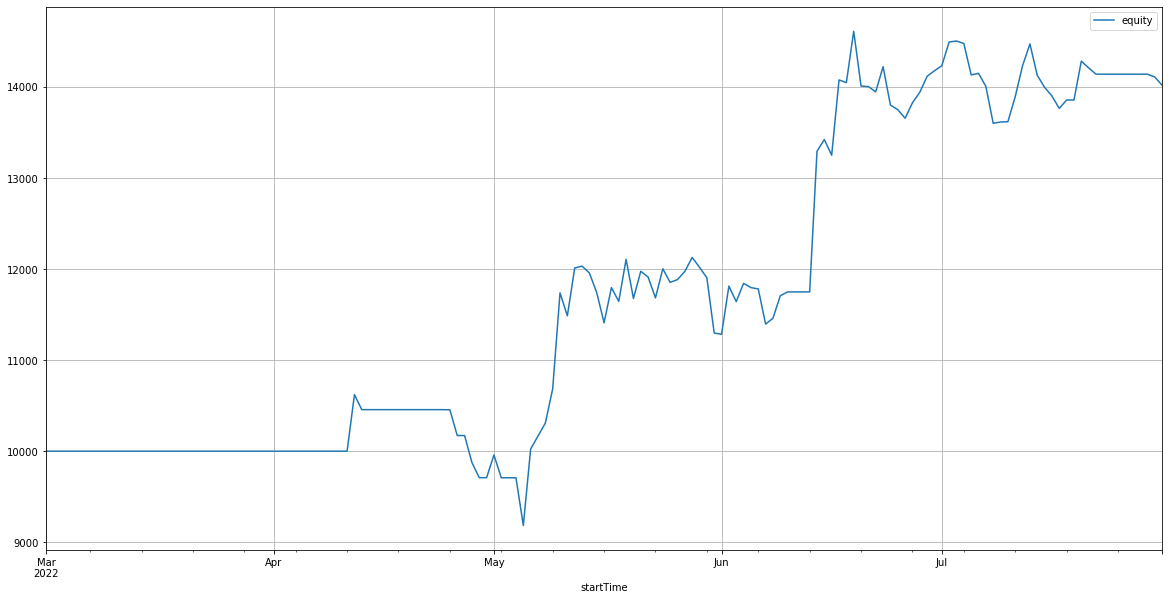

In [151]:
equity[['equity']].plot(figsize=(20,10), grid=True)
mdd

In [73]:
profit = equity['profitfee'].iloc[-1]
yearstd = equity['day_ret'].std()*365**0.5
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
buygrossprofit = sum([i for i in buy_profit_fee_realized_list if i>0])
buygrossloss = sum([i for i in buy_profit_fee_realized_list if i<0])
sellgrossprofit = sum([i for i in sell_profit_fee_realized_list if i>0])
sellgrossloss = sum([i for i in sell_profit_fee_realized_list if i<0])
annualizedreturn = ret*12/5
sharperatio = annualizedreturn / yearstd
print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'annualizedreturn: {np.round(annualizedreturn, 4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'yearstd:{yearstd}')
print(f'sharperatio: {sharperatio}')
print(sum([i for i in profit_fee_list_realized if i > 0]))
print(sum([i for i in profit_fee_list_realized if i < 0]))

profit: $4018.35
return: 40.18%
annualizedreturn: 96.44%
mdd: 13.530000000000001%
calmarRatio: 2.97
tradeTimes: 8
winRate: 50.0%
profitFactor: 5.63
winLossRatio: 5.63
yearstd:0.4333344507082591
sharperatio: 2.2255438669836107
4886.80235482219
-868.4489001285356


In [155]:
#全樣本回測

K=0.4
length_short=5
length_long=35
CCI=105

df_allSample = data
d1 = df_allSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d1 = df_allSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = df_allSample.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = df_allSample.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = df_allSample.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = df_allSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)
dif, dem, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
cci = talib.CCI(df.high, df.low, df.close, timeperiod=14)
df['mashort'] = df['close'].rolling(window=length_short, center=False).mean()
df['malong'] = df['close'].rolling(window=length_long, center=False).mean()
df['macdhist'] = macdhist
df['cci'] = cci
        
time_arr = np.array(df.index)
df_arr = np.array(df)

BS = None
buy = []
sell = []
sellshort = []
buytocover = []
BSlist=[]
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0 and df_arr[i,8] >= CCI:
            tempSize = money / df_arr[i+1,0]
            BS = 'B'
            t = i+1
            buy.append(t)
            t1 = time_arr[i+1]
            BSlist.append('B')

        elif df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0 and df_arr[i,8] <= -CCI:
            tempSize = money / df_arr[i+1,0]
            BS = 'S'
            t = i+1
            sellshort.append(t)
            t1 = time_arr[i+1]
            BSlist.append('S')

    elif BS == 'B':
        profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)

        if df_arr[i,3] < df_arr[t,3]*(1-0.01):
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        elif df_arr[i,3] > df_arr[t,3] * (1+K):
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        elif (df_arr[i,5] < df_arr[i,6] and df_arr[i,7] < 0) or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]

    elif BS == 'S': 
        profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)

        if df_arr[i,3] > df_arr[t,3]*(1+0.01):
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
            
        elif df_arr[i,3] < df_arr[t,3]*(1-K):
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        elif (df_arr[i,5] > df_arr[i,6] and df_arr[i,7] > 0) or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
equity['day_ret'] = equity['equity'].pct_change(1)
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
profit = equity['profitfee'].iloc[-1]
yearstd = equity['day_ret'].std()*365**0.5
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
annualizedreturn = ret*12/19
sharperatio = annualizedreturn / yearstd

In [156]:
month_mdd

,drawdown_percent
startTime,
2020-12-31 00:00:00+00:00,0.000000
2021-01-31 00:00:00+00:00,0.000000
2021-02-28 00:00:00+00:00,0.051173
2021-03-31 00:00:00+00:00,0.098022
2021-04-30 00:00:00+00:00,0.107820
2021-05-31 00:00:00+00:00,0.113459
2021-06-30 00:00:00+00:00,0.098068
2021-07-31 00:00:00+00:00,0.125547
2021-08-31 00:00:00+00:00,0.078781


Text(0, 0.5, 'mdd')

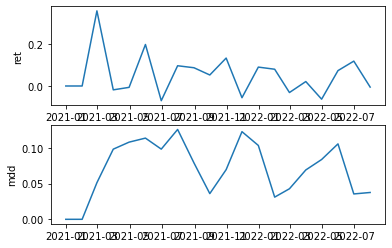

In [157]:
#績效-過程 圖
month_ret = equity['day_ret'].resample(rule = 'M').sum()
month_mdd = abs(equity[['drawdown_percent']]).resample(rule = 'M').max()
month_mdd.name = 'month_mdd'
month_ret.name = 'month_ret'
df_process = pd.DataFrame(month_ret)
df_process = pd.concat([df_process, month_mdd], axis=1)
df_process.to_csv('process.csv')
fig,axes=plt.subplots(2,1)
axes[0].plot(month_ret, label = 'ret')
axes[1].plot(month_mdd, label = 'mdd')
axes[0].set_ylabel('ret')
axes[1].set_ylabel('mdd')

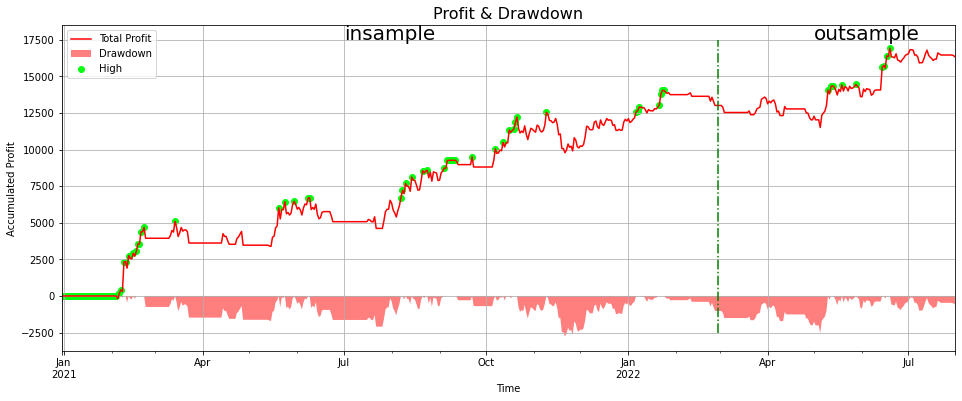

In [160]:
#Profit&Drawdown 圖
fig, ax = plt.subplots(figsize = (16,6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')
plt.vlines(x = '2022-2-28',ymin = -2500, ymax = 17500, color="green", linestyles= 'dashdot')
plt.text('2021-7-1', 17500, 'insample', fontsize = 20)
plt.text('2022-5-1', 17500, 'outsample', fontsize = 20)
plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

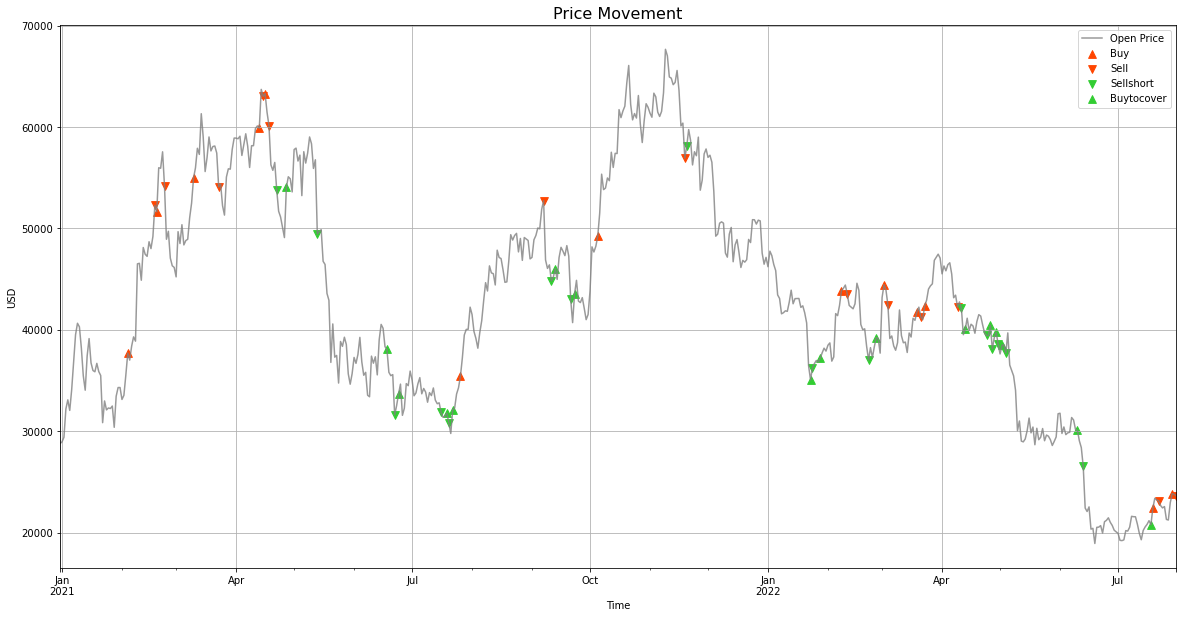

In [161]:
#全樣本價格移動圖
fig, ax = plt.subplots(figsize = (20,10))
df['open'].plot(label = 'Open Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['open'].iloc[buy].index, df['open'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['open'].iloc[sell].index, df['open'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['open'].iloc[sellshort].index, df['open'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['open'].iloc[buytocover].index, df['open'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)
plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

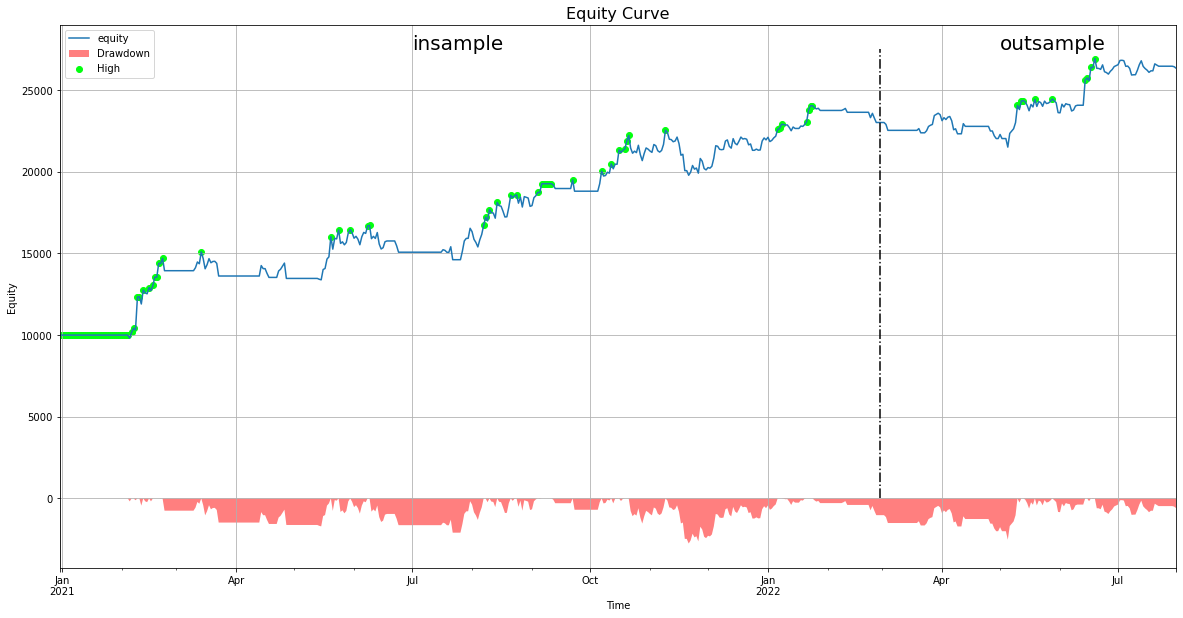

In [38]:
#Equity Curve 圖
high_index = equity[equity['equity'].cummax() == equity['equity']].index
equity[['equity']].plot(figsize=(20,10), grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['equity'].loc[high_index],c = '#02ff0f', label = 'High')
plt.vlines(x = '2022-2-28',ymin = 0, ymax = 27500, color="k", linestyles= 'dashdot')
plt.text('2021-7-1', 27500, 'insample', fontsize = 20)
plt.text('2022-5-1', 27500, 'outsample', fontsize = 20)

plt.legend()
plt.ylabel('Equity')
plt.xlabel('Time')
plt.title('Equity Curve',fontsize  = 16);


In [66]:
profit = equity['profitfee'].iloc[-1]
yearstd = equity['day_ret'].std()*365**0.5
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
buygrossprofit = sum([i for i in buy_profit_fee_realized_list if i>0])
buygrossloss = sum([i for i in buy_profit_fee_realized_list if i<0])
sellgrossprofit = sum([i for i in sell_profit_fee_realized_list if i>0])
sellgrossloss = sum([i for i in sell_profit_fee_realized_list if i<0])
annualizedreturn = ret*12/19
sharperatio = annualizedreturn / yearstd
print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'annualizedreturn: {np.round(annualizedreturn, 4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'yearstd:{yearstd}')
print(f'sharperatio: {sharperatio}')



profit: $16344.67
return: 163.45000000000002%
annualizedreturn: 103.23%
mdd: 12.55%
calmarRatio: 13.02
tradeTimes: 29
winRate: 37.93%
profitFactor: 4.19
winLossRatio: 6.86
yearstd:0.3430571362741713
sharperatio: 3.0091049186604697
